
# Times Series Forecasting with Kaggle Bike Rental Competition
The goal is to combine historical usage patterns with weather data in order to forecast the bike rental demand for a BikeShare program in Washington, DC

The training set consists of the first 19 days of each month, and the test set is the 20th to the end of the month. We need to predict the total count of bikes rented during each hour that is in the test set.

##### 1.) Load files
##### 2.) Split datetime column into numeric columns
##### 3.) Normalize input features
##### 4.) Use PCA to Reduce Dimensionality
##### 5.) Modify the Count column to log1p(count) for training (there are negative values)
##### 6.) Split data into training and test sets



## Data Preparation

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



### 1.) Load files

In [4]:
train_file = '/Users/rabia/ml/kagglecompetitions/bike_sharing/train.csv'
test_file = '/Users/rabia/ml/kagglecompetitions/bike_sharing/test.csv'

df_train =  pd.read_csv(train_file, parse_dates =['datetime'],index_col = 'datetime' )
df_test =  pd.read_csv(test_file, parse_dates =['datetime'],index_col = 'datetime')

columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

#### View the Training Missing Values

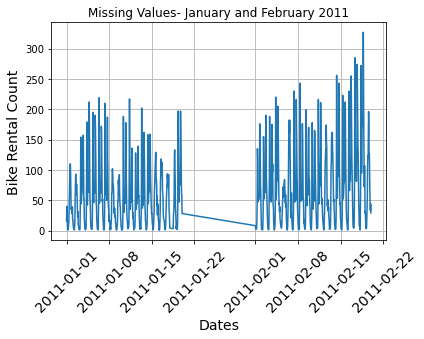

In [5]:
# Missing Values
plt.title('Missing Values- January and February 2011')
plt.plot(df_train['2011-01':'2011-02']['count'])
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Bike Rental Count', fontsize=14)
plt.grid()
plt.show()


### 2.) Split Datetime into numeric columns

In [6]:
def add_datetime_cols(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour


In [7]:
# Adding Datetime cols to training dataset
add_datetime_cols(df_train)

# Adding Datetime cols to test dataset
add_datetime_cols(df_test)

#### View Average Hourly Rentals


In [8]:

groupby_hour = df_train.groupby(['hour'])
average_hour = groupby_hour['count'].mean()

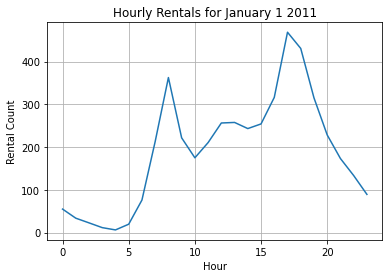

In [9]:

plt.title("Hourly Rentals for January 1 2011")
plt.plot(average_hour.index,average_hour)
plt.xlabel("Hour")
plt.ylabel('Rental Count')
plt.grid(True)


plt.show()

#### Yearly Trend

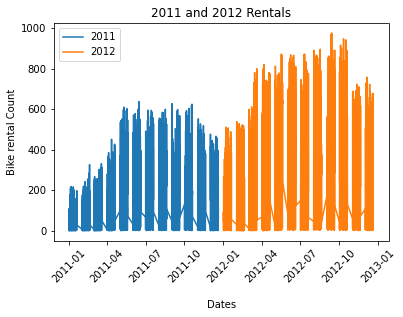

In [10]:

plt.title("2011 and 2012 Rentals")

plt.plot(df_train['2011']['count'],label = '2011')
plt.plot(df_train['2012']['count'], label = '2012')
plt.xticks(rotation = 45, fontsize = 10)
plt.xlabel('\nDates', fontsize = 10)
plt.ylabel('Bike rental Count')
plt.legend()

In [11]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### 3.) Normalize these columns ['temp','atemp','humidity','windspeed']

In [12]:
cols_normalize = ['temp','atemp','humidity','windspeed']

scaler = StandardScaler()
df_train_norm = scaler.fit_transform(df_train[cols_normalize])
df_test_norm = scaler.fit_transform(df_test[cols_normalize])

df_train[cols_normalize] = df_train_norm
df_test[cols_normalize] = df_test_norm

#### Check to see if specified columns were normalized

In [13]:
df_train[cols_normalize]

,temp,atemp,humidity,windspeed
datetime,,,,
2011-01-01 00:00:00,-1.333661,-1.092737,0.993213,-1.567754
2011-01-01 01:00:00,-1.438907,-1.182421,0.941249,-1.567754
2011-01-01 02:00:00,-1.438907,-1.182421,0.941249,-1.567754
2011-01-01 03:00:00,-1.333661,-1.092737,0.681430,-1.567754
2011-01-01 04:00:00,-1.333661,-1.092737,0.681430,-1.567754
...,...,...,...,...
2012-12-19 19:00:00,-0.596935,-0.467310,-0.617666,1.617227
2012-12-19 20:00:00,-0.702182,-0.735182,-0.253919,0.269704
2012-12-19 21:00:00,-0.807428,-0.913959,-0.046064,0.269704


In [14]:
df_test[cols_normalize]

,temp,atemp,humidity,windspeed
datetime,,,,
2011-01-20 00:00:00,-1.235966,-1.440193,-0.421172,1.620888
2011-01-20 01:00:00,-1.235966,-1.181711,-0.421172,-1.531139
2011-01-20 02:00:00,-1.235966,-1.181711,-0.421172,-1.531139
2011-01-20 03:00:00,-1.235966,-1.267682,-0.421172,-0.197558
2011-01-20 04:00:00,-1.235966,-1.267682,-0.421172,-0.197558
...,...,...,...,...
2012-12-31 19:00:00,-1.235966,-1.267682,-0.213831,-0.197558
2012-12-31 20:00:00,-1.235966,-1.267682,-0.213831,-0.197558
2012-12-31 21:00:00,-1.235966,-1.267682,-0.213831,-0.197558


### 4.) Use PCA to Reduce Dimensionality

In [23]:
# Capture 90% variation
pca = PCA(n_components=0.9)

In [27]:
df_train = pca.fit_transform(df_train)
df_test = pca.transform(df_test)
print(type(df_train))

<class 'numpy.ndarray'>



### 5.) Convert count column to log
Log can be used when target represents a count that is non-negative values

In [28]:
df_train["count"] = df_train["count"].map(np.log1p)

df_train


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### 6.) Shuffle data and split data training and validation sets

In [157]:
# Check data before shuffle

df_train.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=10886, freq=None)

In [158]:
# Shuffle data
np.random.seed(10)

l = list(df_train.index)
np.random.shuffle(l)
df_train = df_train.loc[l]



In [159]:
# Check data after shuffle
df_train.index
train_set = int(df_train.shape[0] * .7)



In [161]:
# Write Training Set to CSV File

df_train.iloc[:train_set].to_csv('bikerental_train.csv',\
                                 index = False,\
                                 columns = columns,\
                                 header = False)


In [162]:
# Write Validation Set to CSV File

df_train.iloc[train_set:].to_csv('bikerental_valid.csv',\
                                 index = False,\
                                 columns = columns,\
                                 header = False)


In [165]:
# Create a Test Dataset without target features
df_test.to_csv('bikerental_test.csv',index=True,index_label='datetime')

In [166]:
# Write Columns to a TXT file

with open('bikerental_columns.txt','w') as columns_txt:
    columns_txt.write(','.join(columns))
    